# ECON 416 Final Project

## Are professional forecasters rational?

## Introduction

In the world of business, following economic forecasts closely is crucial. For example, if forecasts for GDP are positive, then a business manager can assume that they will have more disposable income to reinvest in capital. All in all, accurate forecasts allow individuals to have confidence in the fact that they are making the right decisions to grow their investments. 

On the other hand, what happens when forecasts overestimate the potential of an economic indicator? What happens when they underestimate it? These forecasts, if followed, can lead to serious implications such market volatility and an overall loss of credibility for forecasters. How can we be sure that economists can accurately predict the future?

This leads to the research question: Are professional forecasters rational?

To test this question, we will examine the variables Nominal GDP (NGDP), CPI inflation rate (CPI), and unemployment rate (UNEMP). These variables were chosen due to their significance as essential economic indicators for individuals seeking further insights into matters such as the state of the market, business cycles, etc.

We separate these three datasets from the Federal Reserve Bank of Philadelphia's comprehensive data file "SPFmicrodata.csv". However, before performing any operations on the data, preprocessing of the datasets must occur to ensure data integrity. This includes eliminating unnecessary columns, handling null values, and resolving inconsistent IDs used for tracking forecasters. 

## Data Cleaning

### NGDP

Since data cleaning is an iterative process, let us first examine the NGDP dataset. We see that there are columns that are immediately not applicable to the analysis (NGDPA, NGDPB, and INDUSTRY). Our first step is, then, to drop these columns. 

In regard to null values, we will also drop rows that contain null values.

In [1]:
import pandas as pd

NGDP = pd.read_csv('NGDP.csv')

NGDP = NGDP.drop(['INDUSTRY', 'NGDPA', 'NGDPB'], axis=1).dropna() # (1) drop columns

Additionally, if a forecaster has less than 20 years worth of forecasts, we omit them from our analyses in order to account maintain a relatively large sample size of forecasts per forecaster.

You might have asked: why should 20 years worh of forecasts be the cutoff? Well, when we take the number of forecasts per ID, then take the mean of these values, we get an average of 23 responses per forecaster. Accounting for outliers such as individuals who may have over 40 years worth of data, we ultimately decrease this number slightly and arrive at 20 as the lower limit on sample size. 

In [2]:
group_by_id = NGDP.groupby('ID') 
group_by_id.count().mean().head(1) # Derive average amount of responses per forecaster ID

YEAR    23.446746
dtype: float64

Let us also convert each quarter to a specific datetime for simplicity... we will see why later.

In [3]:
NGDP = group_by_id.filter(lambda x: len(x)>20) # Filters out forecasters who have less than 20 responses

QTM = {
    1: '01',
    2: '04',
    3: '07',
    4: '10'
}

NGDP['Month'] = NGDP['QUARTER'].map(QTM)
NGDP['Date'] = pd.to_datetime(NGDP['YEAR'].astype(str )+ '-' + NGDP['Month'], format='%Y-%m')

To fix the ID caveats mentioned in the documentation, we omit forecaster IDs that do not consistently show up in the dataset. If a forecaster drops out of the dataset for 3 or more years, we will omit them from our dataset due to the fact that the same ID can be used for different forecasters. 

In [93]:
NGDP_sorted = NGDP.sort_values(by=['ID', 'Date']).reset_index(drop=True)

values_to_delete = []

prev_row = None # set to None because the first row has no previous row
for index, row in NGDP_sorted.iterrows(): 
    if prev_row is not None and row['ID'] == prev_row['ID']: # loop continues when prev_row and row have the same ID
        year_diff = row['Date'].year - prev_row['Date'].year 
        if year_diff >= 3: # If difference between years is greater than or equal to 3
            values_to_delete.append(index - 1) # add index of prev_row to values_to_delete list
    prev_row = row # change row pointer
    
NGDP_sorted = NGDP_sorted.drop(values_to_delete) # drop collected rows from before
NGDP_sorted = NGDP_sorted.reset_index(drop=True)

In [94]:
NGDP_sorted

,YEAR,QUARTER,ID,NGDP1,NGDP2,NGDP3,NGDP4,NGDP5,NGDP6,Month,Date
0,1968,4,7,871.00,884.00,895.00,911.00,930.00,949.00,10,1968-10-01
1,1969,4,7,943.00,958.00,966.00,972.00,980.00,996.00,10,1969-10-01
2,1970,2,7,960.00,970.00,981.00,998.00,"1,018.00","1,040.00",04,1970-04-01
3,1970,3,7,970.00,981.00,998.00,"1,018.00","1,040.00","1,059.00",07,1970-07-01
4,1970,4,7,986.00,991.00,"1,017.00","1,038.00","1,056.00","1,076.00",10,1970-10-01
...,...,...,...,...,...,...,...,...,...,...,...
6372,2022,4,584,"25,663.30","26,191.78","26,517.38","26,809.57","27,104.66","27,404.33",10,2022-10-01
6373,2023,1,584,"26,132.50","26,439.56","26,674.15","26,955.77","27,274.24","27,612.36",01,2023-01-01
6374,2023,2,584,"26,465.90","26,626.18","26,871.85","27,172.24","27,502.01","27,853.34",04,2023-04-01
6375,2023,3,584,"26,835.00","27,232.79","27,656.77","28,067.51","28,476.57","28,878.70",07,2023-07-01


We will also drop columns 'NGDP1' and 'NGDP6' due to their irrelevance in our analysis.

Finally, we delete rows such that the consecutive row is not immediately one quarter ahead, as this will interfere with the regression. For example, if the first row's date is "1968 Q4," we cannot derive proper revisions for the news variable if the following row is of the date "1969 Q4." This is because revisions occur by quarter.

However, there are certain caveats to the following block of code. If we remove all the occurences of data that do not follow the previous row by a period of 3 months, we will end up with *no data* since it is very rare to find forecasters that have answered the survey every quarter of every year. As such, we can try our best to remove every non-consecutive quarter, but keep in mind that this will not be completely possible, as responsiveness for a survey-based dataset spanning over 60 years is guaranteed to be relatively low.

In [96]:
NGDP_final = NGDP_sorted.drop(['NGDP1', 'NGDP6'], axis=1) # drop two more columns

values_to_delete = []

prev_row = None
for index, row in NGDP_final.iterrows():
    if prev_row is not None and prev_row['ID'] == row['ID'] and row['Date'] != prev_row['Date'] + pd.DateOffset(months=3): # if the current row data is not greater than the previous row data by exactly 3 months 
        values_to_delete.append(index - 1) # add indices of previous row to values_to_delete list
    prev_row = row # set previous row as not None 
    
NGDP_final = NGDP_final.drop(values_to_delete) # drop indices of rows 
NGDP_final = NGDP_final.reset_index(drop=True)
NGDP_final

,YEAR,QUARTER,ID,NGDP2,NGDP3,NGDP4,NGDP5,Month,Date
0,1970,2,7,970.00,981.00,998.00,"1,018.00",04,1970-04-01
1,1970,3,7,981.00,998.00,"1,018.00","1,040.00",07,1970-07-01
2,1970,4,7,991.00,"1,017.00","1,038.00","1,056.00",10,1970-10-01
3,1971,1,7,"1,017.00","1,038.00","1,056.00","1,076.00",01,1971-01-01
4,1971,2,7,"1,038.00","1,056.00","1,076.00","1,097.00",04,1971-04-01
...,...,...,...,...,...,...,...,...,...
5146,2022,4,584,"26,191.78","26,517.38","26,809.57","27,104.66",10,2022-10-01
5147,2023,1,584,"26,439.56","26,674.15","26,955.77","27,274.24",01,2023-01-01
5148,2023,2,584,"26,626.18","26,871.85","27,172.24","27,502.01",04,2023-04-01
5149,2023,3,584,"27,232.79","27,656.77","28,067.51","28,476.57",07,2023-07-01


As you can see, the dates are now mostly arranged by consecutive quarters. 

With this as our resulting cleaned dataframe for 'NGDP.csv', I have outlined the general process of data cleaning for this project. I will not include detailed explanations for the cleaning process of the other 'CPI.csv' and 'UNEMP.csv' files, but it is an iterative process.

### CPI

In [7]:
import pandas as pd

CPI = pd.read_csv('CPI.csv')

CPI = CPI.drop(['INDUSTRY', 'CPI1', 'CPI6', 'CPIA', 'CPIB', 'CPIC'], axis=1).dropna() # (1) drop columns

In [8]:
cpi_group_by_id = CPI.groupby('ID') 
cpi_group_by_id.count().mean().head(1) # Derive average amount of responses per forecaster ID

YEAR    22.821012
dtype: float64

In [9]:
CPI = cpi_group_by_id.filter(lambda x: len(x)>19) # Filters out forecasters who have less than 19 responses

QTM = {
    1: '01',
    2: '04',
    3: '07',
    4: '10'
}

CPI['Month'] = CPI['QUARTER'].map(QTM)
CPI['Date'] = pd.to_datetime(CPI['YEAR'].astype(str )+ '-' + CPI['Month'], format='%Y-%m')

In [99]:
CPI_sorted = CPI.sort_values(by=['ID', 'Date']).reset_index(drop=True)

values_to_delete = []

prev_row = None # set to None
for index, row in CPI_sorted.iterrows(): 
    if prev_row is not None and row['ID'] == prev_row['ID']: # loop continues when prev_row and row are the same
        year_diff = row['Date'].year - prev_row['Date'].year
        if year_diff >= 3: # If difference between years is greater than or equal to 5
            values_to_delete.append(index - 1) # add index of prev_row to to_delete list
    prev_row = row # set prev_row to current row
    
CPI_sorted = CPI_sorted.drop(values_to_delete) # drop collected rows from before
CPI_sorted = CPI_sorted.reset_index(drop=True)

In [98]:
values_to_delete = []

prev_row = None
for index, row in CPI_sorted.iterrows():
    if prev_row is not None and prev_row['ID'] == row['ID'] and row['Date'] != (prev_row['Date'] + pd.DateOffset(months=3)): # if the current row data is not greater than the previous row data by exactly 3 months 
        values_to_delete.append(index - 1) # add indices of previous row to-delete list
    prev_row = row # set previous row as not None 

CPI_final = CPI_sorted.drop(values_to_delete) # drop indices of rows 
CPI_final = CPI_final.reset_index(drop=True)
CPI_final

,YEAR,QUARTER,ID,CPI2,CPI3,CPI4,CPI5,Month,Date
0,1984,2,15,5.20,5.70,6.00,6.40,04,1984-04-01
1,1985,1,15,4.00,4.20,4.60,4.80,01,1985-01-01
2,1985,2,15,4.00,4.00,4.30,4.60,04,1985-04-01
3,1985,3,15,3.50,3.80,4.00,4.30,07,1985-07-01
4,1986,2,15,-1.00,2.50,3.50,3.70,04,1986-04-01
...,...,...,...,...,...,...,...,...,...
3983,2022,4,584,7.68,5.46,5.80,6.01,10,2022-10-01
3984,2023,1,584,2.70,2.79,3.11,3.30,01,2023-01-01
3985,2023,2,584,2.22,2.81,2.98,3.03,04,2023-04-01
3986,2023,3,584,4.73,4.02,4.02,3.99,07,2023-07-01


### UNEMP

In [121]:
import pandas as pd

UNEMP = pd.read_csv('UNEMP.csv')

UNEMP = UNEMP.drop(['INDUSTRY', 'UNEMP1', 'UNEMP6', 'UNEMPA', 'UNEMPB', 'UNEMPC', 'UNEMPD'], axis=1).dropna() # (1) drop columns

In [123]:
unemp_group_by_id = UNEMP.groupby('ID') 
unemp_group_by_id.count().mean().head(1) # Derive average amount of responses per forecaster ID

YEAR    24.414986
dtype: float64

In [150]:
UNEMP = unemp_group_by_id.filter(lambda x: len(x)>20) # Filters out forecasters who have less than 19 responses

QTM = {
    1: '01',
    2: '04',
    3: '07',
    4: '10'
}

UNEMP['Month'] = UNEMP['QUARTER'].map(QTM)
UNEMP['Date'] = pd.to_datetime(UNEMP['YEAR'].astype(str )+ '-' + UNEMP['Month'], format='%Y-%m')

In [151]:
UNEMP_sorted = UNEMP.sort_values(by=['ID', 'Date']).reset_index(drop=True)

values_to_delete = []

prev_row = None # set to None
for index, row in UNEMP_sorted.iterrows(): 
    if prev_row is not None and row['ID'] == prev_row['ID']: # loop continues when prev_row and row are the same
        year_diff = row['Date'].year - prev_row['Date'].year
        if year_diff >= 3: # If difference between years is greater than or equal to 5
            values_to_delete.append(index - 1) # add index of prev_row to to_delete list
    prev_row = row # set prev_row to current row
    
UNEMP_sorted = UNEMP_sorted.drop(values_to_delete) # drop collected rows from before
UNEMP_sorted = UNEMP_sorted.reset_index(drop=True)

In [152]:
values_to_delete = []

prev_row = None
for index, row in UNEMP_sorted.iterrows():
    if prev_row is not None and prev_row['ID'] == row['ID'] and row['Date'] != (prev_row['Date'] + pd.DateOffset(months=3)): # if the current row data is not greater than the previous row data by exactly 3 months 
        values_to_delete.append(index - 1) # add indices of previous row to-delete list
    prev_row = row # set previous row as not None 

UNEMP_final = UNEMP_sorted.drop(values_to_delete) # drop indices of rows 
UNEMP_final = UNEMP_final.reset_index(drop=True)
UNEMP_final

,YEAR,QUARTER,ID,UNEMP2,UNEMP3,UNEMP4,UNEMP5,Month,Date
0,1969,2,1,3.30,3.40,3.50,3.40,04,1969-04-01
1,1969,3,1,3.50,4.10,4.10,4.00,07,1969-07-01
2,1969,4,1,3.70,3.70,4.00,4.10,10,1969-10-01
3,1970,1,1,4.50,5.00,4.30,4.00,01,1970-01-01
4,1970,2,1,4.70,5.00,4.80,4.60,04,1970-04-01
...,...,...,...,...,...,...,...,...,...
5645,2022,4,584,3.70,3.96,4.26,4.55,10,2022-10-01
5646,2023,1,584,3.50,3.62,3.79,3.93,01,2023-01-01
5647,2023,2,584,3.40,3.54,3.63,3.71,04,2023-04-01
5648,2023,3,584,3.50,3.63,3.75,3.86,07,2023-07-01


## Data Analysis

We examine the following simple regression model:

$$\text{Foecast error} = \beta_0 + \beta_1 \text{news} + \varepsilon$$

In this model, foecast error represents the calculation: true value - forecasted value; meanwhile, news represents revisions in forecasts caused by receiving news. To calculate this, we will find the difference of forecasts of the same quarter.

Another limitation that I noticed here, however, is that, for some quarters, there will be more revisions than for other quarters. In addition to this, another problem arises in that forecast error will be difficult to understand given that there are *many* numbers that can represent the forecast error for each quarter. 

To resolve this issue, for each dataset, I have taken the mean of news, and subtracted each of these from the true value of the variables for each quarter. This way, the resulting dataframe only has one value for forecast error and one value for news per quarter, resulting in a more accurate analysis. After this step, I will conduct regression analysis using Python's statsmodel.api library. 

My first step is to match forecasts to the quarter they belong, arranging them in sequential order by ID and date. 

### NGDP

In [153]:
dates, vals, IDs = [], [], []

for index, row in NGDP_final.iterrows(): # iterating through rows
    dates.append(row['Date']) 
    vals.append(row['NGDP2'])
    IDs.append(row['ID'])
    
    if index + 1 < len(NGDP_final) and row['ID'] == NGDP_final.loc[index + 1, 'ID']: # accessing row after current row, only append vals if the next row's ID is the same as the current row's ID 
        dates.append(NGDP_final.loc[index + 1, 'Date'])
        vals.append(NGDP_final.loc[index, 'NGDP3'])
        IDs.append(NGDP_final.loc[index, 'ID'])
        
    if index + 2 < len(NGDP_final) and row['ID'] == NGDP_final.loc[index + 2, 'ID']:
        dates.append(NGDP_final.loc[index + 2, 'Date'])
        vals.append(NGDP_final.loc[index, 'NGDP4'])
        IDs.append(NGDP_final.loc[index, 'ID'])
        
    if index + 3 < len(NGDP_final) and row['ID'] == NGDP_final.loc[index + 3, 'ID']:
        dates.append(NGDP_final.loc[index + 3, 'Date'])
        vals.append(NGDP_final.loc[index, 'NGDP5'])
        IDs.append(NGDP_final.loc[index, 'ID'])
        
res_df = pd.DataFrame({'Date': dates, 'Forecast_Vals': vals, 'ID': IDs})
res_df

,Date,Forecast_Vals,ID
0,1970-04-01,970.00,7
1,1970-07-01,981.00,7
2,1970-10-01,998.00,7
3,1971-01-01,"1,018.00",7
4,1970-07-01,981.00,7
...,...,...,...
19783,2023-07-01,"26,871.85",584
19784,2023-10-01,"27,172.24",584
19785,2023-07-01,"27,232.79",584
19786,2023-10-01,"27,656.77",584


Now, lets sort dataframe values by 'ID' and 'Date' to ensure that we are calculating the right revisions.

In [154]:
res_df = res_df.sort_values(by=['ID', 'Date'])
res_df

,Date,Forecast_Vals,ID
0,1970-04-01,970.00,7
1,1970-07-01,981.00,7
4,1970-07-01,981.00,7
2,1970-10-01,998.00,7
5,1970-10-01,998.00,7
...,...,...,...
19785,2023-07-01,"27,232.79",584
19781,2023-10-01,"27,274.24",584
19784,2023-10-01,"27,172.24",584
19786,2023-10-01,"27,656.77",584


We then make a new dataframe including date, ID and the mean of revisions for a specific quarter.

In [155]:
res_df['Forecast_Vals'] = res_df['Forecast_Vals'].astype(str).str.replace(',', '') # remove commas from column
res_df['Forecast_Vals'] = pd.to_numeric(res_df['Forecast_Vals'])

dates, IDs, revisions = [], [], []

for i in range(len(res_df) - 1):
    curr_row = res_df.iloc[i] # identify indices for current and next row
    next_row = res_df.iloc[i+1]
    
    if curr_row['ID'] == next_row['ID'] and curr_row['Date'] == next_row['Date']: # if the next and current row have the same IDs and dates
        dates.append(curr_row['Date'])
        IDs.append(curr_row['ID'])
        revised = ((next_row['Forecast_Vals'] - curr_row['Forecast_Vals']) / curr_row['Forecast_Vals']) * 100 # calculate news as a %
        revisions.append(round(revised, 4)) # round each revision to 4 decimal places

revisions_df = pd.DataFrame({'Date': dates, 'ID': IDs, 'news (as a %)': revisions}) # make a new df
revisions_df = revisions_df.sort_values(by=['ID', 'Date'])
revisions_df

,Date,ID,news (as a %)
0,1970-07-01,7,0.0000
1,1970-10-01,7,0.0000
2,1970-10-01,7,-0.7014
3,1971-01-01,7,0.0000
4,1971-01-01,7,-0.0982
...,...,...,...
14632,2023-07-01,584,-0.3113
14633,2023-07-01,584,1.3432
14634,2023-10-01,584,-0.3740
14635,2023-10-01,584,1.7832


As you can see, we now have the revisions of each forecaster per quarter as a percentage. Our next step is to aggregate these values...

In [156]:
revisions_df = revisions_df.groupby(['ID', 'Date']).mean()
revisions_df

news (as a %)
ID  Date                     
7   1970-07-01       0.000000
    1970-10-01      -0.350700
    1971-01-01      -0.032733
    1971-04-01      -0.064100
    1971-07-01       0.820700
...                       ...
584 2022-10-01       0.657400
    2023-01-01       1.018800
    2023-04-01       1.036633
    2023-07-01       0.160867
    2023-10-01       0.812633

[5015 rows x 1 columns]

Great! Now, we only have one value, the mean revision percentage, for each quarter. Now we can move on to calculating forecast errors. Let us first import the dataset from the FRED database with true nominal GDP values for each quarter. 

In [157]:
TrueNGDP = pd.read_csv('TrueNGDP.csv', parse_dates=['DATE'])

In [158]:
TrueNGDP = TrueNGDP.rename(columns={'DATE': 'Date', 'GDP': 'True_GDP'})
TrueNGDP

,Date,True_GDP
0,1960-01-01,542.648
1,1960-04-01,541.080
2,1960-07-01,545.604
3,1960-10-01,540.197
4,1961-01-01,545.018
...,...,...
250,2022-07-01,25994.639
251,2022-10-01,26408.405
252,2023-01-01,26813.601
253,2023-04-01,27063.012


To calculate forecast errors, keep in mind that we need to implement the formula: true NGDP - forecasted NGDP. Our dataset makes this tricky to pull off, as there are n number of forecasts for a certain quarter and only one true value for each. To fix this issue, we will take the res_df from a few cells earlier, and take the mean of each forecasted quarter.

In [159]:
forecasted_vals = res_df.groupby(by=['ID', 'Date']).mean()
forecasted_vals.reset_index(inplace=True)
forecasted_vals

,ID,Date,Forecast_Vals
0,7,1970-04-01,970.000000
1,7,1970-07-01,981.000000
2,7,1970-10-01,995.666667
3,7,1971-01-01,1017.500000
4,7,1971-04-01,1038.500000
...,...,...,...
5146,584,2022-10-01,25666.945000
5147,584,2023-01-01,26050.017500
5148,584,2023-04-01,26484.825000
5149,584,2023-07-01,27041.267500


Now, we can implement code that loops through IDs, matching NGDP and Forecast_Vals by dates, and creating a new column of data with differences between the true NGDP values and mean forecasted NGDP values. 

In [160]:
calculate_foecast_errors = pd.merge(forecasted_vals, TrueNGDP, on='Date')
calculate_foecast_errors = calculate_foecast_errors[['Date', 'ID', 'True_GDP', 'Forecast_Vals']].sort_values(by=['ID', 'Date'])
calculate_foecast_errors.reset_index(inplace=True)
calculate_foecast_errors = calculate_foecast_errors.drop(['index'], axis = 1)

On another note, foecast_errors should also be standardized. For example, for the 0th-indexed row, the error seems to be around 100. For the last row, the error is around 600, but this does not necessarily mean that the forecaster was more "incorrect" for recent years. The data is simply not fitted within its context, which was that the True_GDP for the last year *will* be guaranteed to be greater than the True_GDP for the first year.

To properly adjust for this context, we interpret forecast_errors as a percentage too in order to derive correct $\beta_1$ values during regression analysis.

In [161]:
calculate_foecast_errors['foecast_errors'] = ((calculate_foecast_errors['Forecast_Vals'] - calculate_foecast_errors['True_GDP'])/calculate_foecast_errors['True_GDP']) * 100

In [162]:
calculate_foecast_errors

,Date,ID,True_GDP,Forecast_Vals,foecast_errors
0,1970-04-01,7,1067.375,970.000000,-9.122848
1,1970-07-01,7,1086.059,981.000000,-9.673416
2,1970-10-01,7,1088.608,995.666667,-8.537631
3,1971-01-01,7,1135.156,1017.500000,-10.364743
4,1971-04-01,7,1156.271,1038.500000,-10.185415
...,...,...,...,...,...
5126,2022-07-01,584,25994.639,25130.212500,-3.325403
5127,2022-10-01,584,26408.405,25666.945000,-2.807667
5128,2023-01-01,584,26813.601,26050.017500,-2.847747
5129,2023-04-01,584,27063.012,26484.825000,-2.136447


We then put together the final NGDP dataframe that we will run regressions on.

In [163]:
final_df = pd.merge(calculate_foecast_errors, revisions_df, on=['ID', 'Date'])
final_df.drop(['True_GDP', 'Forecast_Vals'], axis = 1, inplace=True)
final_df.rename(columns={'foecast_errors': 'foecast_errors (as a %)'}, inplace=True)
final_df

,Date,ID,foecast_errors (as a %),news (as a %)
0,1970-07-01,7,-9.673416,0.000000
1,1970-10-01,7,-8.537631,-0.350700
2,1971-01-01,7,-10.364743,-0.032733
3,1971-04-01,7,-10.185415,-0.064100
4,1971-07-01,7,-9.779863,0.820700
...,...,...,...,...
4990,2022-07-01,584,-3.325403,0.473733
4991,2022-10-01,584,-2.807667,0.657400
4992,2023-01-01,584,-2.847747,1.018800
4993,2023-04-01,584,-2.136447,1.036633


Let's repeat the same process for the CPI and UNEMP datasets.

### CPI

In [164]:
dates, vals, IDs = [], [], []

for index, row in CPI_final.iterrows(): # iterating through rows
    dates.append(row['Date']) 
    vals.append(row['CPI2'])
    IDs.append(row['ID'])
    
    if index + 1 < len(CPI_final) and row['ID'] == CPI_final.loc[index + 1, 'ID']: # accessing row after current row, only append vals if the next row's ID is the same as the current row's ID 
        dates.append(CPI_final.loc[index + 1, 'Date'])
        vals.append(CPI_final.loc[index, 'CPI3'])
        IDs.append(CPI_final.loc[index, 'ID'])
        
    if index + 2 < len(CPI_final) and row['ID'] == CPI_final.loc[index + 2, 'ID']:
        dates.append(CPI_final.loc[index + 2, 'Date'])
        vals.append(CPI_final.loc[index, 'CPI4'])
        IDs.append(CPI_final.loc[index, 'ID'])
        
    if index + 3 < len(CPI_final) and row['ID'] == CPI_final.loc[index + 3, 'ID']:
        dates.append(CPI_final.loc[index + 3, 'Date'])
        vals.append(CPI_final.loc[index, 'CPI5'])
        IDs.append(CPI_final.loc[index, 'ID'])
        
res1_df = pd.DataFrame({'Date': dates, 'Forecast_Vals': vals, 'ID': IDs})
res1_df = res1_df.sort_values(by=['ID', 'Date'])
res1_df

,Date,Forecast_Vals,ID
0,1984-04-01,5.20,15
1,1985-01-01,5.70,15
4,1985-01-01,4.00,15
2,1985-04-01,6.00,15
5,1985-04-01,4.20,15
...,...,...,...
15433,2023-07-01,4.73,584
15429,2023-10-01,3.30,584
15432,2023-10-01,2.98,584
15434,2023-10-01,4.02,584


In [165]:
res1_df['Forecast_Vals'] = res1_df['Forecast_Vals'].astype(str).str.replace(',', '')
res1_df['Forecast_Vals'] = pd.to_numeric(res1_df['Forecast_Vals'])

dates1, IDs1, revisions1 = [], [], []

for i in range(len(res1_df) - 1):
    curr_row = res1_df.iloc[i]
    next_row = res1_df.iloc[i+1]
    
    if curr_row['ID'] == next_row['ID'] and curr_row['Date'] == next_row['Date']:
        dates1.append(curr_row['Date'])
        IDs1.append(curr_row['ID'])
        revised1 = ((next_row['Forecast_Vals'] - curr_row['Forecast_Vals']) / curr_row['Forecast_Vals'])
        revisions1.append(round(revised1, 4))

revisions1_df = pd.DataFrame({'Date': dates1, 'ID': IDs1, 'news (as a %)': revisions1})
revisions1_df = revisions1_df.sort_values(by=['ID', 'Date'])
revisions1_df

/var/folders/ps/4t258fk13nd9nmx4rjj5zn4w0000gn/T/ipykernel_47640/3181675165.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  revised1 = ((next_row['Forecast_Vals'] - curr_row['Forecast_Vals']) / curr_row['Forecast_Vals'])


,Date,ID,news (as a %)
0,1985-01-01,15,-0.2982
1,1985-04-01,15,-0.3000
2,1985-04-01,15,-0.0476
3,1985-07-01,15,-0.2813
4,1985-07-01,15,-0.1304
...,...,...,...
11443,2023-07-01,584,-0.0965
11444,2023-07-01,584,0.6833
11445,2023-10-01,584,-0.0970
11446,2023-10-01,584,0.3490


In [166]:
revisions1_df = revisions1_df.groupby(['ID', 'Date']).mean()
revisions1_df

news (as a %)
ID  Date                     
15  1985-01-01      -0.298200
    1985-04-01      -0.173800
    1985-07-01      -0.178900
    1986-04-01      -0.494567
    1986-07-01      -0.141800
...                       ...
584 2022-10-01       0.360433
    2023-01-01      -0.061233
    2023-04-01      -0.086233
    2023-07-01       0.034767
    2023-10-01       0.023467

[3902 rows x 1 columns]

In [167]:
TrueCPI = pd.read_csv('TrueCPI.csv', parse_dates=['DATE'])

In [168]:
TrueCPI = TrueCPI.rename(columns={'DATE': 'Date', 'CORESTICKM159SFRBATL': 'True_CPI'})
TrueCPI

,Date,True_CPI
0,1967-12-01,3.383497
1,1968-01-01,3.659987
2,1968-02-01,3.682012
3,1968-03-01,4.151668
4,1968-04-01,4.165427
...,...,...
666,2023-06-01,5.626529
667,2023-07-01,5.456089
668,2023-08-01,5.217343
669,2023-09-01,5.008782


In [169]:
forecasted1_vals = res1_df.groupby(by=['ID', 'Date']).mean()
forecasted1_vals.reset_index(inplace=True)
forecasted1_vals

,ID,Date,Forecast_Vals
0,15,1984-04-01,5.200000
1,15,1985-01-01,4.850000
2,15,1985-04-01,4.733333
3,15,1985-07-01,4.625000
4,15,1986-04-01,2.975000
...,...,...,...
3983,584,2022-10-01,4.975000
3984,584,2023-01-01,4.057500
3985,584,2023-04-01,3.692500
3986,584,2023-07-01,4.165000


In [170]:
calculate_foecast_errors1 = pd.merge(forecasted1_vals, TrueCPI, on='Date')
calculate_foecast_errors1 = calculate_foecast_errors1[['Date', 'ID', 'True_CPI', 'Forecast_Vals']].sort_values(by=['ID', 'Date'])
calculate_foecast_errors1.reset_index(inplace=True)
calculate_foecast_errors1 = calculate_foecast_errors1.drop(['index'], axis = 1)

In [171]:
calculate_foecast_errors1['foecast_errors (as a %)'] = ((calculate_foecast_errors1['Forecast_Vals'] - calculate_foecast_errors1['True_CPI'])/calculate_foecast_errors1['True_CPI'])
calculate_foecast_errors1

,Date,ID,True_CPI,Forecast_Vals,foecast_errors (as a %)
0,1984-04-01,15,4.646319,5.200000,0.119166
1,1985-01-01,15,4.726710,4.850000,0.026084
2,1985-04-01,15,4.754134,4.733333,-0.004375
3,1985-07-01,15,4.948295,4.625000,-0.065335
4,1986-04-01,15,5.370857,2.975000,-0.446085
...,...,...,...,...,...
3983,2022-10-01,584,6.364809,4.975000,-0.218358
3984,2023-01-01,584,6.554492,4.057500,-0.380959
3985,2023-04-01,584,6.322749,3.692500,-0.415998
3986,2023-07-01,584,5.456089,4.165000,-0.236633


**Note**** for CPI, since both True_CPI and Forecast_Vals are already expressed as a percentage, their difference will automatically be expressed as a percentage. Hence, no further calculations are needed to turn forecast_errors into a percentage. The same will apply for the data analysis for the UNEMP section...

In [173]:
final_df1 = pd.merge(calculate_foecast_errors1, revisions1_df, on=['ID', 'Date'])
final_df1.drop(['True_CPI', 'Forecast_Vals'], axis = 1, inplace=True)
final_df1.replace([np.inf, -np.inf], np.nan, inplace=True) # some values have been divivided by 0, resulting in inf values that need to be excluded
final_df1.dropna(inplace=True)
final_df1

,Date,ID,foecast_errors (as a %),news (as a %)
0,1985-01-01,15,0.026084,-0.298200
1,1985-04-01,15,-0.004375,-0.173800
2,1985-07-01,15,-0.065335,-0.178900
3,1986-04-01,15,-0.446085,-0.494567
4,1986-07-01,15,-0.306573,-0.141800
...,...,...,...,...
3897,2022-10-01,584,-0.218358,0.360433
3898,2023-01-01,584,-0.380959,-0.061233
3899,2023-04-01,584,-0.415998,-0.086233
3900,2023-07-01,584,-0.236633,0.034767


### UNEMP

In [174]:
dates, vals, IDs = [], [], []

for index, row in UNEMP_final.iterrows(): # iterating through rows
    dates.append(row['Date']) 
    vals.append(row['UNEMP2'])
    IDs.append(row['ID'])
    
    if index + 1 < len(UNEMP_final) and row['ID'] == UNEMP_final.loc[index + 1, 'ID']: # accessing row after current row, only append vals if the next row's ID is the same as the current row's ID 
        dates.append(UNEMP_final.loc[index + 1, 'Date'])
        vals.append(UNEMP_final.loc[index, 'UNEMP3'])
        IDs.append(UNEMP_final.loc[index, 'ID'])
        
    if index + 2 < len(UNEMP_final) and row['ID'] == UNEMP_final.loc[index + 2, 'ID']:
        dates.append(UNEMP_final.loc[index + 2, 'Date'])
        vals.append(UNEMP_final.loc[index, 'UNEMP4'])
        IDs.append(UNEMP_final.loc[index, 'ID'])
        
    if index + 3 < len(UNEMP_final) and row['ID'] == UNEMP_final.loc[index + 3, 'ID']:
        dates.append(UNEMP_final.loc[index + 3, 'Date'])
        vals.append(UNEMP_final.loc[index, 'UNEMP5'])
        IDs.append(UNEMP_final.loc[index, 'ID'])
        
res2_df = pd.DataFrame({'Date': dates, 'Forecast_Vals': vals, 'ID': IDs})
res2_df = res2_df.sort_values(by=['ID', 'Date'])
res2_df

,Date,Forecast_Vals,ID
0,1969-04-01,3.30,1
1,1969-07-01,3.40,1
4,1969-07-01,3.50,1
2,1969-10-01,3.50,1
5,1969-10-01,4.10,1
...,...,...,...
21739,2023-07-01,3.50,584
21735,2023-10-01,3.93,584
21738,2023-10-01,3.63,584
21740,2023-10-01,3.63,584


In [175]:
res2_df['Forecast_Vals'] = res2_df['Forecast_Vals'].astype(str).str.replace(',', '')
res2_df['Forecast_Vals'] = pd.to_numeric(res2_df['Forecast_Vals'])

dates2, IDs2, revisions2 = [], [], []

for i in range(len(res2_df) - 1):
    curr_row = res2_df.iloc[i]
    next_row = res2_df.iloc[i+1]
    
    if curr_row['ID'] == next_row['ID'] and curr_row['Date'] == next_row['Date']:
        dates2.append(curr_row['Date'])
        IDs2.append(curr_row['ID'])
        revised2 = ((next_row['Forecast_Vals'] - curr_row['Forecast_Vals']) / curr_row['Forecast_Vals'])
        revisions2.append(round(revised2, 4))

revisions2_df = pd.DataFrame({'Date': dates2, 'ID': IDs2, 'news (as a %)': revisions2})
revisions2_df = revisions2_df.sort_values(by=['ID', 'Date'])
revisions2_df

,Date,ID,news (as a %)
0,1969-07-01,1,0.0294
1,1969-10-01,1,0.1714
2,1969-10-01,1,-0.0976
3,1970-01-01,1,0.2059
4,1970-01-01,1,-0.0976
...,...,...,...
16087,2023-07-01,584,-0.0660
16088,2023-07-01,584,-0.0113
16089,2023-10-01,584,-0.0763
16090,2023-10-01,584,0.0000


In [176]:
revisions2_df = revisions2_df.groupby(['ID', 'Date']).mean()
revisions2_df

news (as a %)
ID  Date                     
1   1969-07-01       0.029400
    1969-10-01       0.036900
    1970-01-01       0.108167
    1970-04-01       0.063333
    1970-07-01       0.070533
...                       ...
584 2022-10-01      -0.028567
    2023-01-01      -0.056933
    2023-04-01      -0.060667
    2023-07-01      -0.081433
    2023-10-01      -0.025433

[5507 rows x 1 columns]

In [177]:
TrueUNEMP = pd.read_csv('True_UNEMP.csv', parse_dates=['DATE'])

In [178]:
TrueUNEMP = TrueUNEMP.rename(columns={'DATE': 'Date', 'UNRATE': 'True_UNEMP'})
TrueUNEMP

,Date,True_UNEMP
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
906,2023-07-01,3.5
907,2023-08-01,3.8
908,2023-09-01,3.8
909,2023-10-01,3.9


In [179]:
forecasted2_vals = res2_df.groupby(by=['ID', 'Date']).mean()
forecasted2_vals.reset_index(inplace=True)
forecasted2_vals

,ID,Date,Forecast_Vals
0,1,1969-04-01,3.300000
1,1,1969-07-01,3.450000
2,1,1969-10-01,3.766667
3,1,1970-01-01,3.925000
4,1,1970-04-01,4.425000
...,...,...,...
5645,584,2022-10-01,3.857500
5646,584,2023-01-01,3.897500
5647,584,2023-04-01,3.855000
5648,584,2023-07-01,3.845000


In [180]:
calculate_foecast_errors2 = pd.merge(forecasted2_vals, TrueUNEMP, on='Date')
calculate_foecast_errors2 = calculate_foecast_errors2[['Date', 'ID', 'True_UNEMP', 'Forecast_Vals']].sort_values(by=['ID', 'Date'])
calculate_foecast_errors2.reset_index(inplace=True)
calculate_foecast_errors2 = calculate_foecast_errors2.drop(['index'], axis = 1)

In [181]:
calculate_foecast_errors2['foecast_errors (as a %)'] = ((calculate_foecast_errors2['Forecast_Vals'] - calculate_foecast_errors2['True_UNEMP'])/calculate_foecast_errors2['True_UNEMP'])
calculate_foecast_errors2

,Date,ID,True_UNEMP,Forecast_Vals,foecast_errors (as a %)
0,1969-04-01,1,3.4,3.300000,-0.029412
1,1969-07-01,1,3.5,3.450000,-0.014286
2,1969-10-01,1,3.7,3.766667,0.018018
3,1970-01-01,1,3.9,3.925000,0.006410
4,1970-04-01,1,4.6,4.425000,-0.038043
...,...,...,...,...,...
5645,2022-10-01,584,3.7,3.857500,0.042568
5646,2023-01-01,584,3.4,3.897500,0.146324
5647,2023-04-01,584,3.4,3.855000,0.133824
5648,2023-07-01,584,3.5,3.845000,0.098571


In [182]:
final_df2 = pd.merge(calculate_foecast_errors2, revisions2_df, on=['ID', 'Date'])
final_df2.drop(['True_UNEMP', 'Forecast_Vals'], axis = 1, inplace=True)
final_df2

,Date,ID,foecast_errors (as a %),news (as a %)
0,1969-07-01,1,-0.014286,0.029400
1,1969-10-01,1,0.018018,0.036900
2,1970-01-01,1,0.006410,0.108167
3,1970-04-01,1,-0.038043,0.063333
4,1970-07-01,1,-0.080000,0.070533
...,...,...,...,...
5502,2022-10-01,584,0.042568,-0.028567
5503,2023-01-01,584,0.146324,-0.056933
5504,2023-04-01,584,0.133824,-0.060667
5505,2023-07-01,584,0.098571,-0.081433


Now that we have dataframes for NGDP, CPI, and UNEMP, let's move on to the next section.

## Regression Analysis & Visualizations

### NGDP

In [183]:
import statsmodels.api as sm

beta1 = []
rsquared = []
p_val = []

regressions = final_df.groupby('ID')

for ID, data in regressions:
    x = data['news (as a %)']
    x = sm.add_constant(x)
    
    model = sm.OLS(data['foecast_errors (as a %)'], x)
    result = model.fit()
    print(result.summary())
    
    beta_coefs = result.params['news (as a %)']
    beta1.append(beta_coefs)
    
    rsquared.append(result.rsquared)
    p_val.append(result.f_pvalue)

                               OLS Regression Results                              
Dep. Variable:     foecast_errors (as a %)   R-squared:                       0.707
Model:                                 OLS   Adj. R-squared:                  0.698
Method:                      Least Squares   F-statistic:                     74.98
Date:                     Sun, 10 Dec 2023   Prob (F-statistic):           8.87e-10
Time:                             20:36:54   Log-Likelihood:                -53.781
No. Observations:                       33   AIC:                             111.6
Df Residuals:                           31   BIC:                             114.6
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_st

                               OLS Regression Results                              
Dep. Variable:     foecast_errors (as a %)   R-squared:                       0.121
Model:                                 OLS   Adj. R-squared:                  0.107
Method:                      Least Squares   F-statistic:                     8.924
Date:                     Sun, 10 Dec 2023   Prob (F-statistic):            0.00397
Time:                             20:36:54   Log-Likelihood:                -148.34
No. Observations:                       67   AIC:                             300.7
Df Residuals:                           65   BIC:                             305.1
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Before we plot these values and create visualizations for them, let us interpret some other values from the results of the regression analysis. 

In [184]:
import numpy as np

rsqrd = np.mean(rsquared)
print(f'R^2: {rsqrd}')

pval = np.mean(p_val)
print(f'p-value: {pval}')

R^2: 0.5792061901583331
p-value: 0.011052184630384872


By taking the mean of the collected $R^2$ values, we see that approximately 57% of the variability in forecast errors can be explained by the news variable. Thus, this variable is valuable to our analysis, and the news variable is significant in predicting the variability of forecast errors.

Additionally, since the mean p-value across all regressions is $< 0.05$, this reconfirms that the news variable is, indeed significant to our analysis. As such, we can now proceed to creating visualizations of our data, expositing the new insights that we collected from our research and, finally, coming to a conclusion about whether forecasters are accurate or not.

Text(0.5, 0, 'News (as a %)')

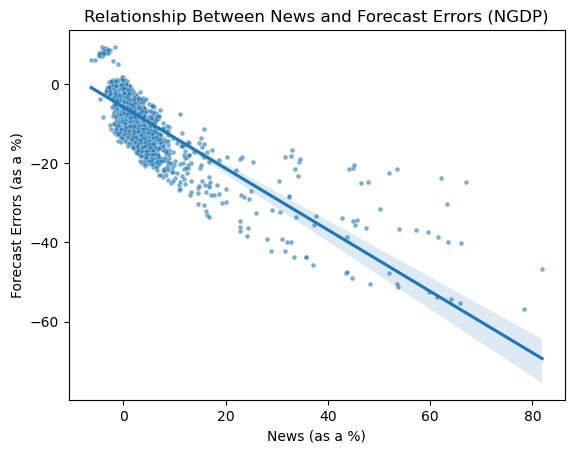

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=final_df, x='news (as a %)', y='foecast_errors (as a %)', s=12, alpha=0.6)
sns.regplot(data=final_df, x='news (as a %)', y='foecast_errors (as a %)', scatter=False)

plt.title('Relationship Between News and Forecast Errors (NGDP)')
plt.ylabel('Forecast Errors (as a %)')
plt.xlabel('News (as a %)')

This visualization supports the idea that there is a strong, negative relationship between news and forecast errors.

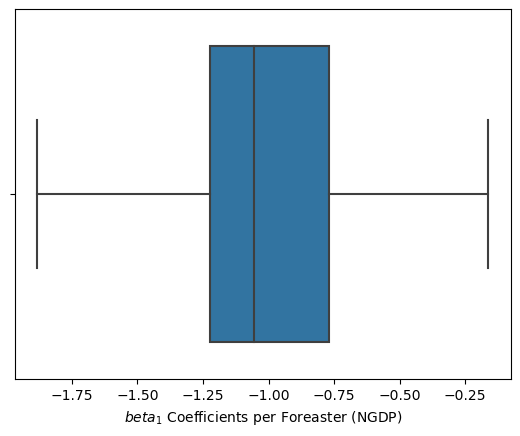

<Figure size 800x600 with 0 Axes>

In [186]:
import matplotlib.pyplot as plt

sns.boxplot(x=beta1)
plt.xlabel('$beta_1$ Coefficients per Foreaster (NGDP)')
plt.figure(figsize=(8, 6))
plt.show()

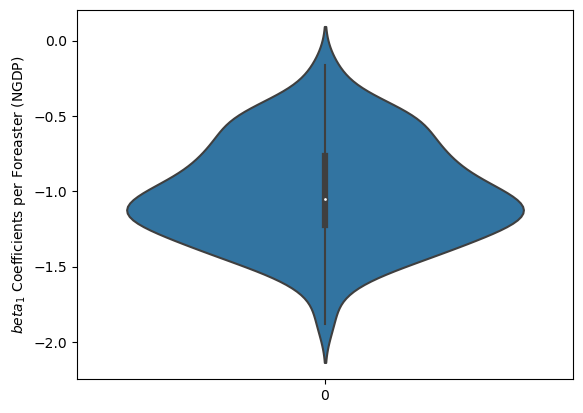

<Figure size 800x600 with 0 Axes>

In [187]:
sns.violinplot(data=beta1)
plt.ylabel('$beta_1$ Coefficients per Foreaster (NGDP)')
plt.figure(figsize=(8, 6))
plt.show()

Finally, the boxplot of the collected $\beta_1$ coefficients show that the interquartile range lies between the values -1.25 and -0.75, meaning that, generally, a 1% increase in revisions cause forecast errors to be affected by -0.75% to -1.25%.

The violinplot further suports this, as the probability density is centered around these values as well.

From these visualizations, we revisit the question: are professional forecasters rational?

Well, the collected $\beta_1$'s tell us that forecasters are not rational, since $\beta_1 \neq 0$. Since $\beta_1 < 0$, we conclude that, when it comes to NGDP, forecasters have a tendency to overreact to news— albeit slightly.

### CPI

In [188]:
import statsmodels.api as sm

beta1_CPI = []
rsquared_CPI = []
p_val_CPI = []

regressions1 = final_df1.groupby('ID')

for ID, data in regressions1:
    x = data['news (as a %)']
    x = sm.add_constant(x)
    
    model = sm.OLS(data['foecast_errors (as a %)'], x)
    result = model.fit()
    print(result.summary())
    
    beta_coefs = result.params['news (as a %)']
    beta1_CPI.append(beta_coefs)
    
    rsquared_CPI.append(result.rsquared)
    p_val_CPI.append(result.f_pvalue)
    

/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_s

                               OLS Regression Results                              
Dep. Variable:     foecast_errors (as a %)   R-squared:                       0.243
Model:                                 OLS   Adj. R-squared:                  0.192
Method:                      Least Squares   F-statistic:                     4.805
Date:                     Sun, 10 Dec 2023   Prob (F-statistic):             0.0446
Time:                             20:37:39   Log-Likelihood:                 11.607
No. Observations:                       17   AIC:                            -19.21
Df Residuals:                           15   BIC:                            -17.55
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [189]:
rsqrd = np.mean(rsquared_CPI)
print(f'R^2: {rsqrd}')

pval = np.mean(p_val_CPI)
print(f'p-value: {pval}')

R^2: 0.11475820907759059
p-value: 0.24213086736030315


By taking the mean of the collected $R^2$ values, we see that approximately 11% of the variability in forecast errors can be explained by the news variable. Thus, this variable, again, is not that great for our analysis. What this suggests is that, revisions in CPI do not have as great of an impact on forecast errors as revisions in NGDP do.

Additionally, since the mean p-value across all regressions is not $< 0.05$, this reconfirms to us that coefficients collected in examining CPI are not statistically significant to the interpretation of forecast errors.

(-5.1745836083334975, 6.320123807759145)

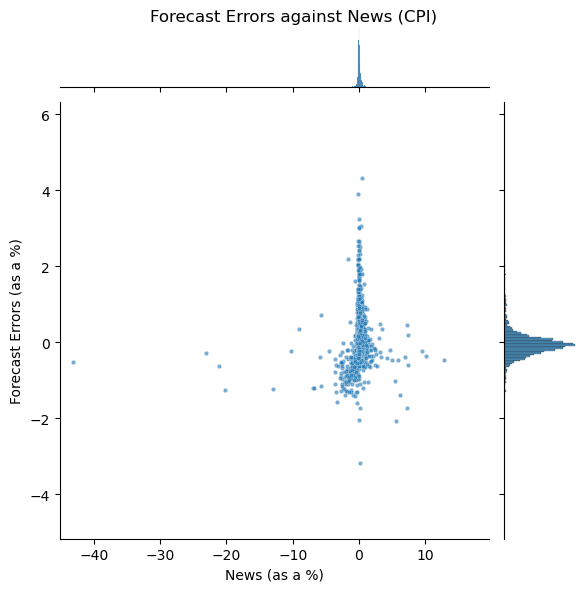

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.jointplot(data=final_df1, x='news (as a %)', y='foecast_errors (as a %)', s=10, alpha=0.6)

plt.suptitle('Forecast Errors against News (CPI)')
plt.ylabel('Forecast Errors (as a %)')
plt.xlabel('News (as a %)')

plt.xlim(final_df1['news (as a %)'].min() - 2, final_df1['news (as a %)'].max() - 4)
plt.ylim(final_df1['foecast_errors (as a %)'].min() - 2 , final_df1['foecast_errors (as a %)'].max() + 2)

This plot demonstrates how, although there seems to be little variability in % revisions for news, it results in a wider variation of forecast errors. Thus, in selecting CPI as a variable, it appears that adding another independent variable in addition to news in the regression model could be better for gaining statistically significant insight on forecast errors.

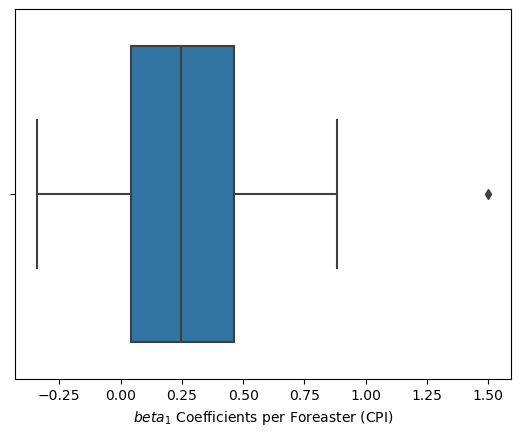

<Figure size 800x600 with 0 Axes>

In [191]:
import matplotlib.pyplot as plt

sns.boxplot(x=beta1_CPI)
plt.xlabel('$beta_1$ Coefficients per Foreaster (CPI)')
plt.figure(figsize=(8, 6))
plt.show()

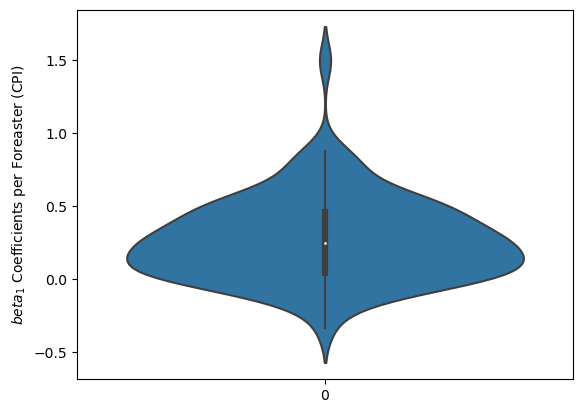

<Figure size 800x600 with 0 Axes>

In [192]:
sns.violinplot(data=beta1_CPI)
plt.ylabel('$beta_1$ Coefficients per Foreaster (CPI)')
plt.figure(figsize=(8, 6))
plt.show()

Furthermore, the boxplot of the collected $\beta_1$ coefficients show that the interquartile range lies between the values 0.00 and 0.50, meaning that, generally, a 1% increase in revisions causes forecast errors to be affected by 0.00% to 0.50%.

The violinplot further suports this, as the probability density is centered around these values as well, with some outliers centered around the northern region of the boxplot and the violinplot.

Again, the collected $\beta_1$'s demonstrate that forecasters are not rational, since $\beta_1 \neq 0$. Since $\beta_1 > 0$, we conclude that, when it comes to CPI, forecasters have a a slight tendency to *underreact* to revisions in CPI. This is surprising since we previously concluded that forecasters overreact to revisions in GDP.

However, since a 1% increase in revisions only affects forecast errors by 0.00% to 0.50%, this implies that, when estimating CPI, forecasters seem to be more accurate than in estimating GDP.

Unfortunately, the conclusions drawn from these two plots do not mean much, since p is not $< 0.05$... 

### UNEMP

In [194]:
import statsmodels.api as sm

beta1_UNEMP = []
rsquared_UNEMP = []
p_val_UNEMP = []

regressions2 = final_df2.groupby('ID')

for ID, data in regressions2:
    x = data['news (as a %)']
    x = sm.add_constant(x)
    
    model = sm.OLS(data['foecast_errors (as a %)'], x)
    result = model.fit()
    print(result.summary())
    
    beta_coefs = result.params['news (as a %)']
    beta1_UNEMP.append(beta_coefs)
    
    rsquared_UNEMP.append(result.rsquared)
    p_val_UNEMP.append(result.f_pvalue)
    

/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_s

                               OLS Regression Results                              
Dep. Variable:     foecast_errors (as a %)   R-squared:                       0.354
Model:                                 OLS   Adj. R-squared:                  0.314
Method:                      Least Squares   F-statistic:                     8.770
Date:                     Sun, 10 Dec 2023   Prob (F-statistic):            0.00919
Time:                             20:38:54   Log-Likelihood:                 32.491
No. Observations:                       18   AIC:                            -60.98
Df Residuals:                           16   BIC:                            -59.20
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/andriazheng/anaconda3/lib/python3.11/site-packages/scipy/stats/_s

In [195]:
rsqrd = np.mean(rsquared_UNEMP)
print(f'R^2: {rsqrd}')

pval = np.mean(p_val_UNEMP)
print(f'p-value: {pval}')

R^2: 0.6738118042503005
p-value: 0.008328701832460143


For UNEMP, we see a greater mean of collected $R^2$ values than for NGDP. We also observe that the p-value for UNEMP is, again, lower than that for NGDP. This tells us that, for prediction of the UNEMP variable, news is a great choice for an independent variable. Thus, news largely affects the accuracy of forecasters in making predictions for UNEMP. 

Text(0.5, 0, 'News (as a %)')

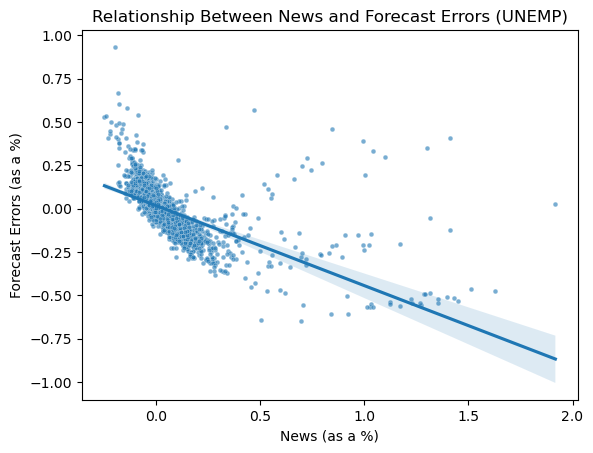

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=final_df2, x='news (as a %)', y='foecast_errors (as a %)', s=12, alpha=0.6)
sns.regplot(data=final_df2, x='news (as a %)', y='foecast_errors (as a %)', scatter=False)

plt.title('Relationship Between News and Forecast Errors (UNEMP)')
plt.ylabel('Forecast Errors (as a %)')
plt.xlabel('News (as a %)')

As expected, there is also a strong, negative relationship between news and forecast errors for UNEMP.

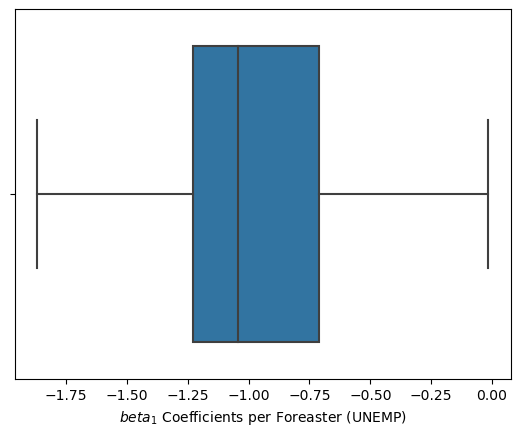

<Figure size 800x600 with 0 Axes>

In [197]:
import matplotlib.pyplot as plt

sns.boxplot(x=beta1_UNEMP)
plt.xlabel('$beta_1$ Coefficients per Foreaster (UNEMP)')
plt.figure(figsize=(8, 6))
plt.show()

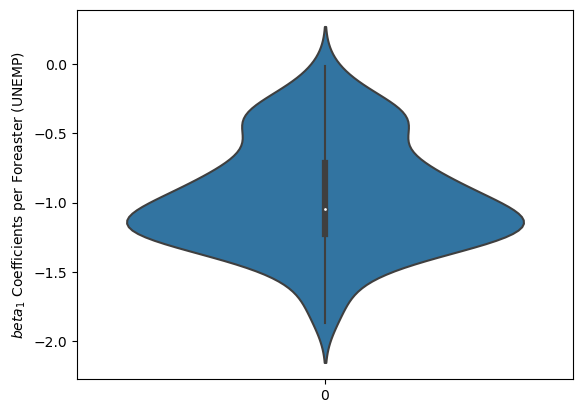

<Figure size 800x600 with 0 Axes>

In [198]:
sns.violinplot(data=beta1_UNEMP)
plt.ylabel('$beta_1$ Coefficients per Foreaster (UNEMP)')
plt.figure(figsize=(8, 6))
plt.show()

Unsurprisingly, the boxplots and violinplots for NGDP and UNEMP look quite similar! Coincidentally, the interquartile range for UNEMP also lies between the values -1.25 and -0.75, meaning that, again, a 1% increase in revisions cause forecast errors to be affected by -0.75% to -1.25%.

The collected $\beta_1$'s for UNEMP tell us that forecasters are not rational since $\beta_1 < 0$, but we can conclude that, when it comes to UNEMP, forecasters also have a tendency to overreact to news.

## Conclusion

Based on the evidence collected, we can finally arrive at a conclusion. Economic forecasters, for the most part, are relatively accurate!

From the distribution of $\beta_1$'s collected in using NGDP and UNEMP as variables, we see that forecasters have a tendency to overreact to news. For these variables, $\beta_1$ has a mean of about -1%.

Although these values are not 0, they are not far from it, which demonstrates that, although forecasters are not 100% rational in making revisions to their forecasts upon hearing news, they are, for the most part, accurate. When it comes to predicting the future, forecasters, in actuality, are pretty good at it despite often facing criticisms.

What we can also draw from these two numbers and from the p-value in using CPI as a variable, is that forecasters seem to be more accurate in predicting an economic factor that is not so subject to large changes. In predicting CPI, for example, a forecaster might rely less on news because major changes in policy might be less likely to affect consumer prices. Perhaps it is also due to the fact that economists are more aware that consumers also take more time to adjust to policy changes, hence decreasing the need to make revisions for CPI. On the other hand, nominal GDP and unemployment, which both include far more considerations apart from consumer preferences and supply chains, and whose effects can take place more quickly, are guaranteed be affected by news regarding changes in policy.

Thus, in conclusion, economic forecasters are as accurate as can be given human limitations, but accuracy also depends on the scale of the variable in which they are measuring, making the possibility of a "good forecast" more possible for one variable, but less possible for another.